In [ ]:
!pip install --user scprep phate magic-impute mnnpy scanpy

*Don't forget to restart the runtime.*

In [1]:
import scprep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phate
import graphtools as gt
import magic
import os

# Batch correction and gene visualization

Here we're going to run batch correction on a two-batch dataset of peripheral blood mononuclear cells (PBMCs) from 10X Genomics. The two batches are from two healthy donors, one using the 10X version 2 chemistry, and the other using the 10X version 3 chemistry.

Note that in this case, we have no reason to believe that there would be a genuine biological difference between the two batches (both donors are healthy) and good reason to believe that would be a genuine technical difference between the two batches (they were run with different chemistries). You should only use batch correction if you are confident that the effect you are removing is not genuine biology.

## 1. Loading preprocessed data

We have loaded and preprocessed the PBMC data for you, though you can download the raw files from https://support.10xgenomics.com/single-cell-gene-expression/datasets

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that this is only useful if your data has two separate batches.

In [2]:
scprep.io.download.download_google_drive(id='1Ufsqot_Ir43M9XQhVNC27a6yW-_vvC9H',
                                         destination='data.pickle.gz')
scprep.io.download.download_google_drive(id='1BHji8Dy_jn8sIC60YsXm4sxVbFafnYWI',
                                         destination='metadata.pickle.gz')
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

## 2. Imputation with MAGIC

As mentioned previously, scRNAseq data suffers from various forms of noise - chiefly dropout or under counting of mRNA molecules in single cells. Since analysis of sparse, noisey and non-uniform expression data can be challenging, we impute missing data values with MAGIC. This will aid in the visualization of gene expression and later with more complex analyses.

Since PBMCs have 3 major cell types (T cells, B cells, and monocytes), we will selectively impute genes that are specific for this cell types. Selectively imputing genes helps save on memory.

In [3]:
marker_genes = scprep.select.get_gene_set(data, exact_word=['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14'])

data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.95 seconds.
    Calculating affinities...
    Calculated affinities in 1.95 seconds.
  Calculated graph and diffusion operator in 13.19 seconds.
  Calculating imputation...
Calculated MAGIC in 14.81 seconds.


In [4]:
data_magic.head()

,CD14 (ENSG00000170458),CD19 (ENSG00000177455),CD4 (ENSG00000010610),CD8A (ENSG00000153563),ITGAX (ENSG00000140678)
AAACCTGAGAAGGCCT-1_Donor_1,1.837633,0.010673,0.906357,0.024870,0.327761
AAACCTGAGACAGACC-1_Donor_1,1.628307,0.009000,0.854518,0.031461,0.319669
AAACCTGAGATAGTCA-1_Donor_1,2.216056,0.021713,0.597026,0.040887,0.223146
AAACCTGAGCGCCTCA-1_Donor_1,0.033293,0.012806,0.230356,0.471385,0.021654
AAACCTGAGGCATGGT-1_Donor_1,0.017394,0.030278,0.229169,0.318202,0.003342


## 3. Characterizing the Batch Effect

Whenever you suspect there is a batch effect, you should always start by asking yourself, "How do I know this difference doesn't represent biologically relevant variation between samples?"

The best way to do this is to start by assessing which genes are most differentially expressed between samples. Here we'll use the differential expression toolkit implemented in [`scprep.stats.differential_expression`](scprep.stats.differential_expression). Another good toolkit for calculating differential expression is [DiffxPy](https://github.com/theislab/diffxpy/).

In [11]:
# Calculate the differential expression by calculating the t-statistic between samples
results = scprep.stats.differential_expression(data.loc[metadata['sample_labels'] == 'Donor_1'],
                                    data.loc[metadata['sample_labels'] == 'Donor_2'],
                                    measure='ttest')

#### Print out the top 20 genes differentially expressed between samples

In [16]:
results.iloc[0:20,:]

,ttest,rank
RPL28 (ENSG00000108107),229.784986,0
RPL26 (ENSG00000161970),221.262047,1
RPS15 (ENSG00000115268),207.336194,2
RPL10 (ENSG00000147403),204.523862,3
B2M (ENSG00000166710),195.827612,4
RPS14 (ENSG00000164587),195.644367,5
RPLP1 (ENSG00000137818),191.706117,6
TMSB4X (ENSG00000205542),190.883911,7
RPS2 (ENSG00000140988),190.236420,8
RPS9 (ENSG00000170889),190.135579,9


#### Plot the distribution of expression for each gene between samples

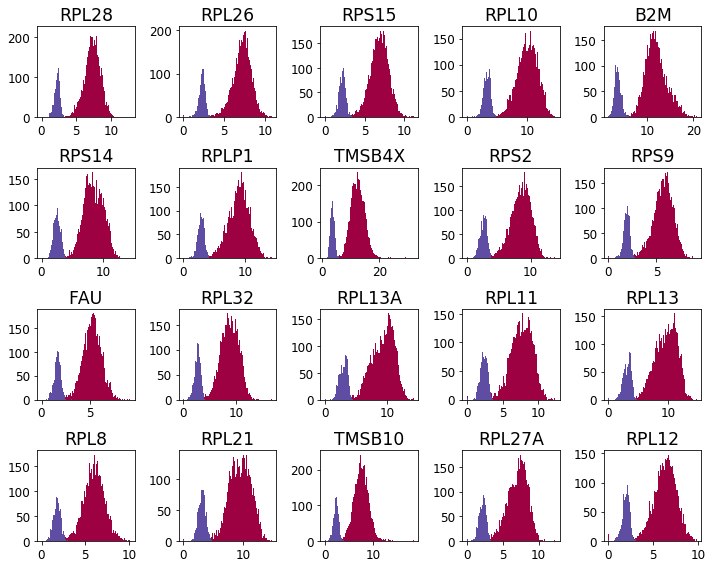

In [46]:
# Create the figure and subplot axes
fig, axes = plt.subplots(4,5, figsize=(2*5, 2*4))

# Iterate over the axes
for i, ax in enumerate(axes.flatten()):
    # Get the i'th most differentially expressed gene
    curr_gene = results.iloc[i].name
    # Split the gene name to get the symbol
    gene_symbol = curr_gene.split(' ')[0]
    
    # Get the raw expression for the current gene
    exp = np.array(data[curr_gene])
    
    # Get expression per sample
    exp_donor_1 = exp[metadata['sample_labels'] == 'Donor_1']
    exp_donor_2 = exp[metadata['sample_labels'] == 'Donor_2']
    
    # Plot the histograms
    scprep.plot.histogram(exp_donor_1, range=(exp.min(), exp.max()), bins=100, 
                          ax=ax, color='#9E0141', ylabel='')
    scprep.plot.histogram(exp_donor_2, range=(exp.min(), exp.max()), bins=100, 
                          ax=ax, color='#5E4DA2', ylabel='', title=gene_symbol)

# Fit subplots into figure neatly
fig.tight_layout()

### Discussion

1. What do you notice about the kinds of genes that are the top 20 or 50 differentially expressed between samples?
    - The genes are mostly ribosomal proteins or housekeeping genes. All are higher in Donor 1 vs Donor 2
    

2. Do you think these differences are biologically relevant? What sort of technical factors could influence the detection of these genes?
    - Ribosomal proteins have higher GC content than the genome-wide average (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC155282/). Differences in primers or RT efficiency could influence the detection of these genes.

## 4. Visualizing data

Here, we're going to visualize our data with PHATE. If you'd like to use other visualization techniques such as UMAP or tSNE please go ahead!

In [5]:
data_phate = phate.PHATE().fit_transform(data)
# alternative: umap.UMAP(), sklearn.manifold.TSNE()

Calculating PHATE...
  Running PHATE on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.61 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 10.56 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.44 seconds.
  Calculated landmark operator in 16.17 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.36 seconds.
Calculated PHATE in 33.17 seconds.


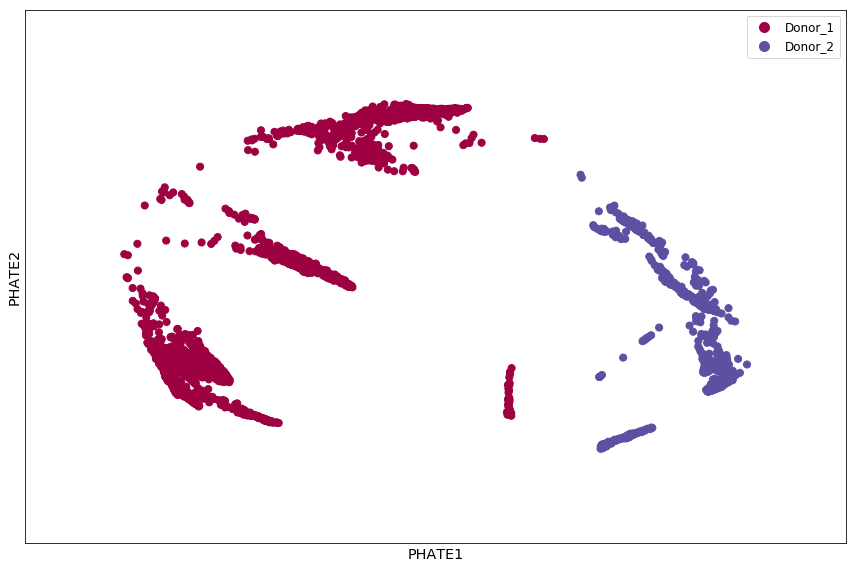

In [6]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", s = 50)

### Discussion

1. What do you notice about this visualization? 
    - The visualization splits pretty clearly into the two batches -- a.k.a., there is a 'batch effect'. However, we don't know whether or not it's a technical effect at this stage.
2. What do you think is driving this effect?
    - It could be a biological difference between the two batches, or a technical difference due to some effect of the sequencing process. <something about the truth

## 5. Visualizing imputed gene expression on visualization

To check our suspicions about this dataset, let's check some cell type specific markers.

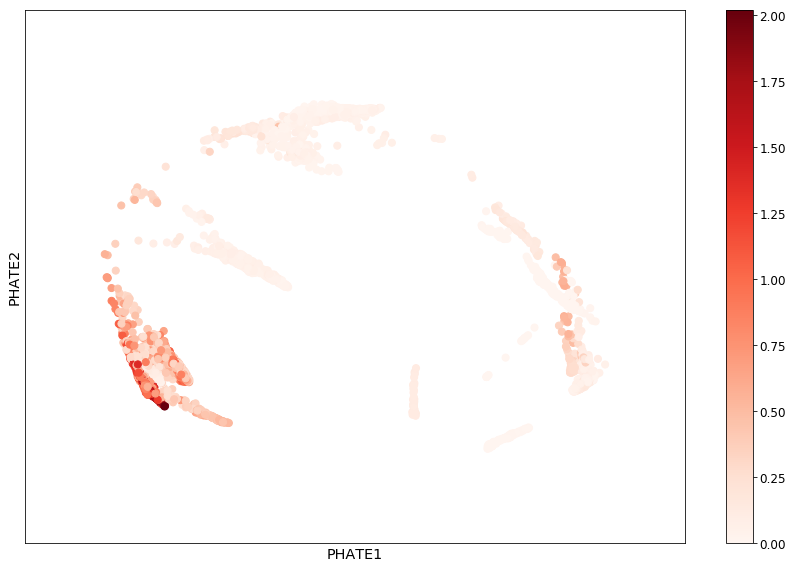

In [7]:
expression = scprep.select.select_cols(data_magic, exact_word='CD8A')

scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

### Exercise - plotting gene expression

Visualize each of the following marker genes and describe what you find: CD4, CD8A, CD19, ITGAX, CD14. Try using both raw and imputed data.

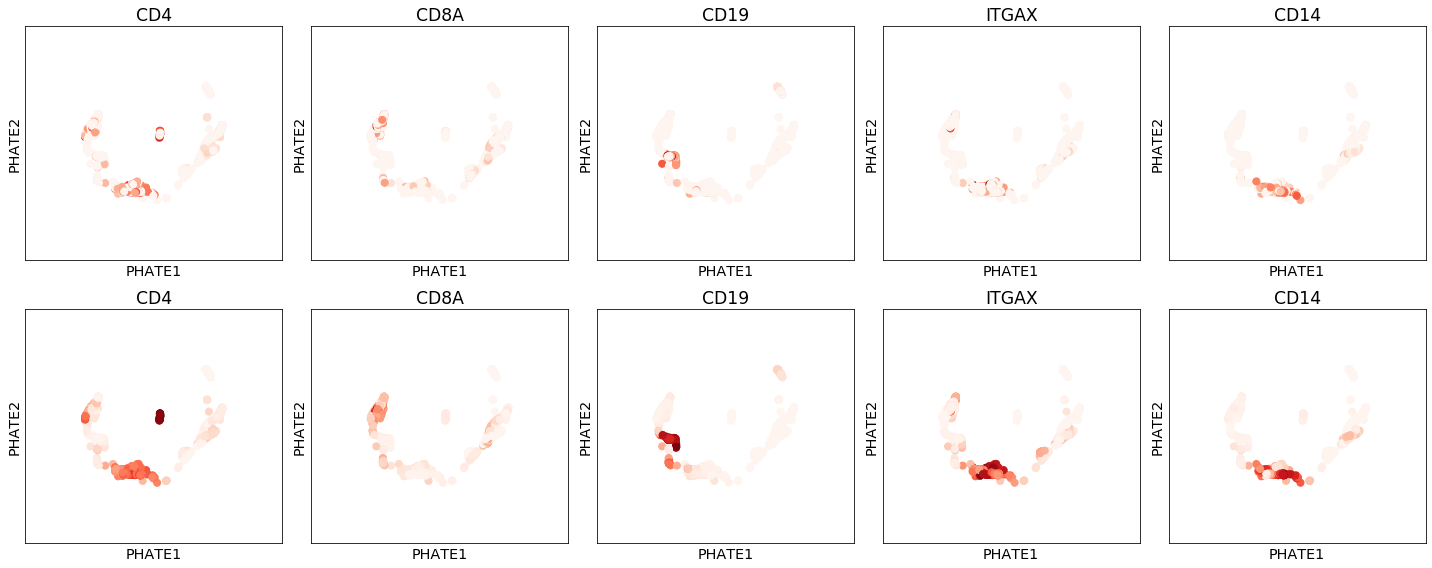

In [10]:
genes = ['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14']

fig, axes = plt.subplots(2, len(genes), figsize=(len(genes)*4, 8))

for X, ax in zip([data, data_magic], axes):
    for gene, ax in zip(genes, ax):
        expression = scprep.select.select_cols(X, exact_word=gene)
        scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds", title=gene,
                              ticks=False, label_prefix="PHATE", s = 50, ax=ax, legend=False)

plt.tight_layout()

### Discussion

1. What do you notice about the expression of each of these markers?
    - Everything is more highly expression in Donor 1 than Donor 2. If we look a little closer, we can see multiple populations (one in each donor) expressing some markers that we have reason to believe should only exist in one cell type (e.g. CD14, CD8A).
2. What else might you check before deciding that the difference between the batches is a technical effect?
    - Is there is a biological reason why this might be the case? I would run differential expression between the batches to try to identify what is driving the difference and see if it makes biological sense.

## 6. Correcting differences between samples

There are several algorithms that try to correct systemic sample level differences present in single cell datasets. Here, we will implement MNN correction to try and remove these differences. Herein, we will first create an AnnData object from our data before running it through MNN to get corrected data. We can then use this data to re-impute gene expression and re-visualize our data.

In [11]:
import scanpy as sc

pbmc_anndata = sc.AnnData(X=data, obs = metadata)

In [12]:
batches = ["Donor_1","Donor_2"]
alldata = {}

for batch in batches:
    alldata[batch] = pbmc_anndata[pbmc_anndata.obs['sample_labels']==batch,]


In [13]:
cdata = sc.external.pp.mnn_correct(alldata['Donor_1'], alldata['Donor_2'], svd_dim=50, 
                                  batch_key = 'sample_labels', batch_categories=["Donor_1","Donor_2"])

/home/scottgigante/.local/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f782a4e81f0>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/scottgigante/.local/lib/python3.8/site-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/scottgigante/.local/lib/python3.8/site-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f782a4e81f0>)
[2] During: typing of call at /home/scottgigante/.local/lib/python3.8/site-packages/

/home/scottgigante/.local/lib/python3.8/site-packages/numba/object_mode_passes.py:177: NumbaWarning: Function "adjust_s_variance" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../../../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 201:
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
    distance1 = np.zeros((data1.shape[0], 2), dtype=np.float32)
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/scottgigante/.local/lib/python3.8/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 201:
def adjust_s_variance(data1, data2, curcell, curv

Performing cosine normalization...


/home/scottgigante/.local/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f782a4e81f0>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/scottgigante/.local/lib/python3.8/site-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/scottgigante/.local/lib/python3.8/site-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f782a4e81f0>)
[2] During: typing of call at /home/scottgigante/.local/lib/python3.8/site-packages/

Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/home/scottgigante/.local/lib/python3.8/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/scottgigante/.local/lib/python3.8/site-packages/mnnpy/utils.py (94)

File "../../../../../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/home/scottgigante/.local/lib/python3.8/site-packages/numba/object_mode_passes.py:177: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../../../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 i

  Computing correction vectors...


/home/scottgigante/.local/lib/python3.8/site-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/scottgigante/.local/lib/python3.8/site-packages/mnnpy/utils.py (107)

File "../../../../../.local/lib/python3.8/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32))
/home/scottgigante/.local/lib/python3.8/site-packages/numba/object_mode_passes.py:177: NumbaWarning: Function "compute_correction" was compiled in object mode without forceobj=True.

File "../../../../../.local/lib/python3.8/site-packages/mn

  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


## 6. Visualizing gene expression on corrected data

Now that we have a batch corrected dataset, let's visualize imputed gene expression on the aligned manifold. Let us know what you think!

In [14]:
cdata_magic = magic.MAGIC().fit_transform(cdata[0], genes=marker_genes)

cdata_magic = pd.DataFrame(cdata_magic.X)
cdata_magic.columns = marker_genes
cdata_index = data.index

Calculating MAGIC...
  Running MAGIC on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.69 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.25 seconds.
    Calculating affinities...
    Calculated affinities in 2.17 seconds.
  Calculated graph and diffusion operator in 8.12 seconds.
  Calculating imputation...
Calculated MAGIC in 8.19 seconds.


In [15]:
cdata_phate = phate.PHATE().fit_transform(cdata[0])

Calculating PHATE...
  Running PHATE on 5199 points and 10817 features.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 5.96 seconds.
  Calculating landmark operator...
    Calculating SVD...


/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:935: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  warnings.warn("Passing all_or_any to check_is_fitted is deprecated"


    Calculated SVD in 0.36 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.48 seconds.
  Calculated landmark operator in 27.00 seconds.
  Calculating optimal t...


/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:935: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  warnings.warn("Passing all_or_any to check_is_fitted is deprecated"


    Automatically selected t = 18
  Calculated optimal t in 4.51 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.04 seconds.
Calculated PHATE in 44.17 seconds.


/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:935: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  warnings.warn("Passing all_or_any to check_is_fitted is deprecated"


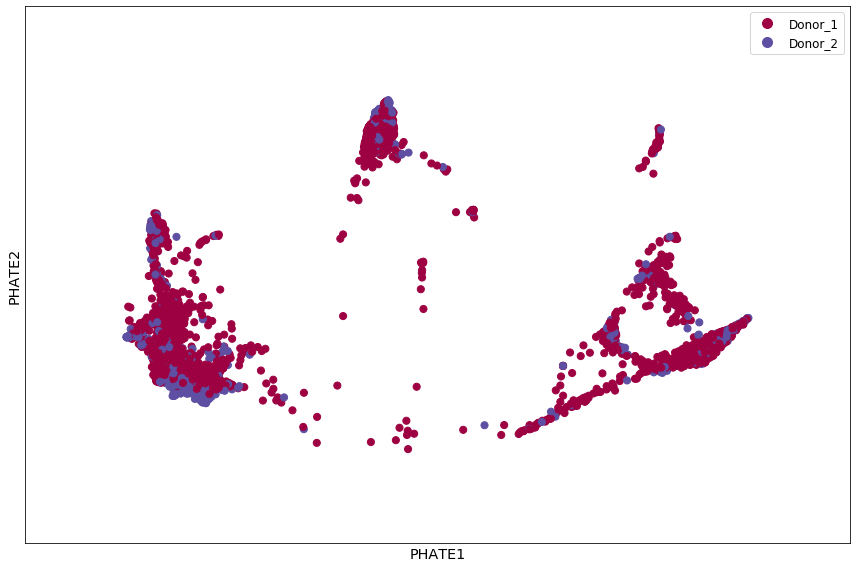

In [16]:
scprep.plot.scatter2d(cdata_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", s = 50)

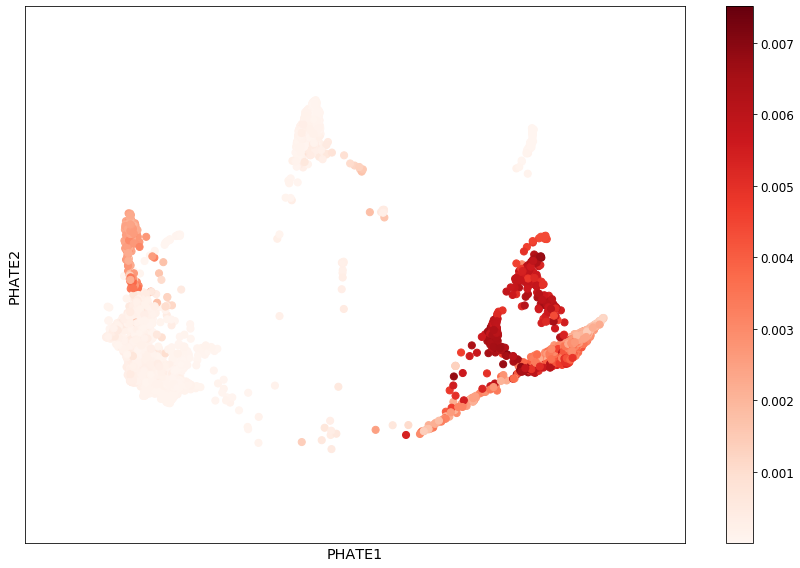

In [17]:
expression = scprep.select.select_cols(cdata_magic, exact_word='ITGAX') # Please enter each of the marker genes here

scprep.plot.scatter2d(cdata_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

### Exercise - plotting gene expression

Visualize each of the following marker genes and describe what you find: CD4, CD8A, CD19, ITGAX, CD14. Try using both raw and imputed data.

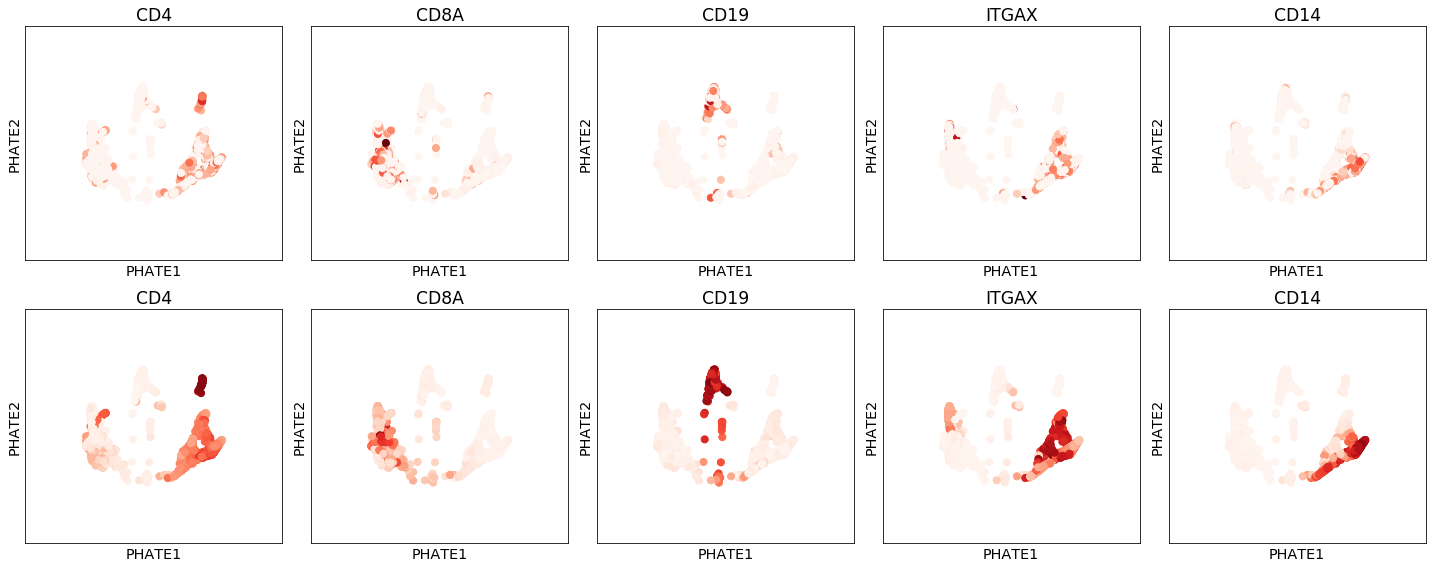

In [22]:
genes = ['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14']

fig, axes = plt.subplots(2, len(genes), figsize=(len(genes)*4, 8))

for X, ax in zip([cdata[0].to_df(), cdata_magic], axes):
    for gene, ax in zip(genes, ax):
        expression = scprep.select.select_cols(X, exact_word=gene)
        scprep.plot.scatter2d(cdata_phate, c=expression, figsize=(12,8), cmap="Reds", title=gene,
                              ticks=False, label_prefix="PHATE", s = 50, ax=ax, legend=False)

plt.tight_layout()

### Discussion

1. What do you notice about the expression of each of these markers? How does it compare to the visualization before batch correction?
    - The expression of these known PBMC markers now segments the data into clear cell types.
2. When is it a good idea to apply batch correction to a dataset?
    - If there is a clear difference between batches, there is no biological reason why this should be the case, and all efforts have been made to attempt to remove by difference through better preprocessing.
3. Can you think of any risks of doing batch correction?
    - If a cell type exists in one batch and not the other, it may be removed (coerced to look like another). If there is a genuine biological difference between cell types that exist in both datasets, that may also be removed.